# TD3

### **Note on this tutorials:**
**They mostly contain low level implementations explaining what is going on inside the library.**

**Most of the stuff explained here is already available out of the box for your usage.**

If you do not care about the detailed implementation with code, go to the [Library Basics]/algorithms how to/td3, there is a 20 liner version

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch_optimizer as optim


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# comment out if you are not using themes
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')

# ---
frame_size = 10
batch_size = 25
n_epochs   = 100
plot_every = 30
step       = 0
# --- 

tqdm.pandas()

In [3]:
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl", # cache will generate after you run
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

In [14]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
            
def run_tests():
    test_batch = next(iter(env.test_dataloader))
    losses = td3_update(step, test_batch, params, writer, learn=False)
    
    gen_actions = debug['gen_action']
    true_actions = env.base.embeddings.detach().cpu().numpy()
    
    f = plotter.kde_reconstruction_error(ad, gen_actions, true_actions, cuda)
    writer.add_figure('rec_error',f, losses['step'])
    return losses

In [15]:
def td3_update(step, batch, params, writer, learn=True):
    
    state, action, reward, next_state, done = recnn.data.get_base_batch(batch)
    
    # --------------------------------------------------------#
    # Value Learning
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()),
                         params['noise_std']).to(cuda)
    noise = torch.clamp(noise, -params['noise_clip'], params['noise_clip'])
    next_action += noise
    
    with torch.no_grad():
        target_q_value1  = target_value_net1(next_state, next_action)
        target_q_value2  = target_value_net2(next_state, next_action)
        target_q_value   = torch.min(target_q_value1, target_q_value2)
        expected_q_value = reward + (1.0 - done) * params['gamma'] * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    if learn:
        value_optimizer1.zero_grad()
        value_loss1.backward()
        value_optimizer1.step()

        value_optimizer2.zero_grad()
        value_loss2.backward()
        value_optimizer2.step()
    else:
        debug['next_action'] = next_action
        writer.add_figure('next_action',
                    recnn.utils.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('value1', q_value1, step)
        writer.add_histogram('value2', q_value2, step)
        writer.add_histogram('target_value', target_q_value, step)
        writer.add_histogram('expected_value', expected_q_value, step)

    # --------------------------------------------------------#
    # Policy learning

    gen_action = policy_net(state)
    policy_loss = value_net1(state, gen_action)
    policy_loss = -policy_loss
    
        
    if not learn: 
        debug['gen_action'] = gen_action
        writer.add_figure('gen_action',
                    recnn.utils.pairwise_distances_fig(gen_action[:50]), step)
        writer.add_histogram('policy_loss', policy_loss, step)
        
    policy_loss = policy_loss.mean()
    
    # delayed policy update
    if step % params['policy_update'] == 0 and learn:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
    
    losses = {'value1': value_loss1.item(),
              'value2': value_loss2.item(),
              'policy': policy_loss.item(),
              'step'  : step}
    recnn.utils.write_losses(writer, losses, kind='train' if learn else 'test')
    return losses

In [16]:
# === TD3 settings ===
params = {
    'gamma': 0.99,
    'noise_std': 0.5,
    'noise_clip': 3,
    'soft_tau': 0.001,
    'policy_update': 10,
    
    'policy_lr': 1e-5,
    'value_lr': 1e-5,
    
    'actor_weight_init': 25e-2,
    'critic_weight_init': 6e-1,
}
# === end ===

In [17]:
value_net1  = recnn.nn.models.Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
value_net2 = recnn.nn.models.Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
policy_net = recnn.nn.models.Actor(1290, 128, 256, params['actor_weight_init']).to(cuda)

target_value_net1 = recnn.nn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.nn.models.Critic(1290, 128, 256).to(cuda)
target_policy_net = recnn.nn.models.Actor(1290, 128, 256).to(cuda)

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

In [18]:
value_criterion = nn.MSELoss()

value_optimizer1 = optim.Ranger(value_net1.parameters(), lr=params['value_lr'],  weight_decay=1e-2)
value_optimizer2 = optim.Ranger(value_net2.parameters(), lr=params['value_lr'],  weight_decay=1e-2)
policy_optimizer = optim.Ranger(policy_net.parameters(), lr=params['policy_lr'], weight_decay=1e-5)

ad = recnn.nn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()


loss = {
    'train': {'value1': [], 'value2': [], 'policy': [], 'step': []},
    'test': {'value1': [], 'value2': [], 'policy': [], 'step': []}
    }
debug = {}

writer = SummaryWriter(log_dir='../../runs')
plotter = recnn.utils.Plotter(loss, [['value1', 'policy']],)

step 5130


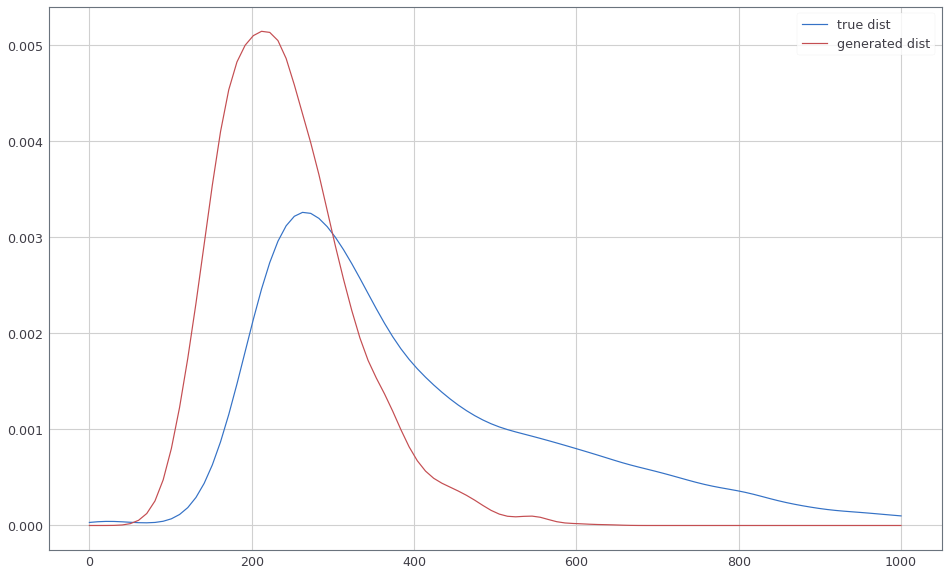

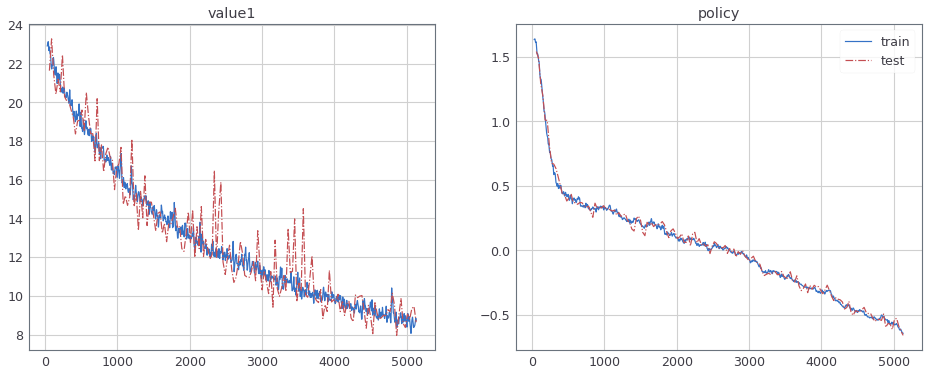

97%|█████████▋| 5110/5263 [09:25<00:16,  9.03it/s]


KeyboardInterrupt: 

In [19]:
for epoch in range(n_epochs):
    for batch in tqdm(env.train_dataloader):
        loss = td3_update(step, batch, params, writer)
        plotter.log_losses(loss)
        step += 1
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            test_loss = run_tests()
            plotter.log_losses(test_loss, test=True)
            plotter.plot_loss()

In [20]:
torch.save(value_net1.state_dict(), "../../models/td3_value.pt")
torch.save(policy_net.state_dict(), "../../models/td3_policy.pt")

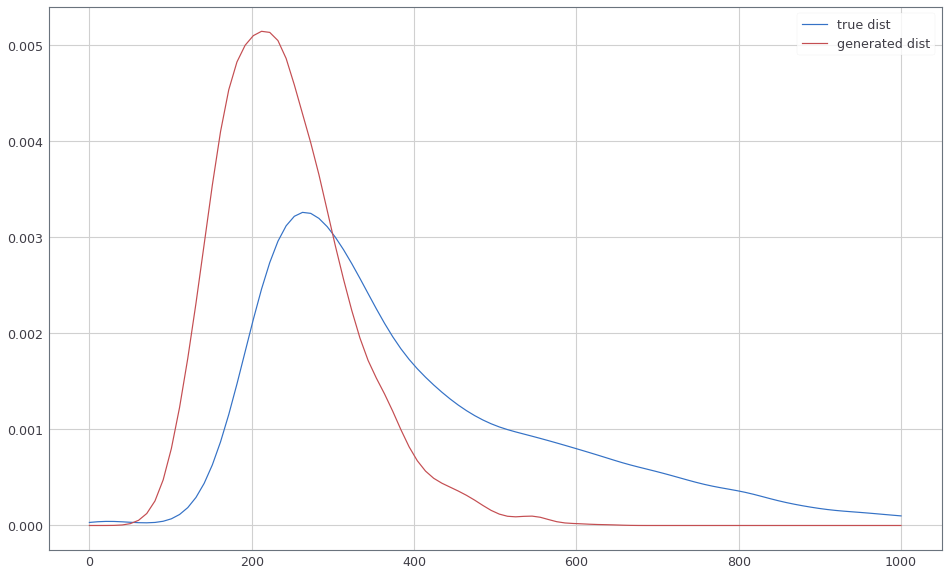

In [22]:
gen_actions = debug['gen_action']
true_actions = env.base.embeddings.numpy()

ad = recnn.nn.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

plotter.plot_kde_reconstruction_error(ad, gen_actions, true_actions, cuda)